In [ ]:
# import packages
import numpy as np
import pandas as pd
import random
import scipy.stats as stats
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
from joblib import dump, load
import joblib

'get the zone-wise distance of the h3 zones'
# get the h3 zone center coordinates using h3 package
import h3


from datetime import datetime

# Data Pipelining

In [ ]:
'Zone H3 location Masking'

# Make a set of all the order zones
OrZone_address = None # list of grid addresses for order zones

# repeat the zone name substitution with DestZone
DestZone_address = OrZone_address + None # list of grid addresses for destination zones

OrZone_dict = {f'zone {i+1}':OrZone_address[i] for i in range(len(OrZone_address))}
DestZone_dict = {f'zone {i+1}':DestZone_address[i] for i in range(len(DestZone_address))}

OrZone_center_dict = {f'zone {i+1}':h3.h3_to_geo(OrZone_address[i]) for i in range(len(OrZone_address))}
DestZone_center_dict = {f'zone {i+1}':h3.h3_to_geo(DestZone_address[i]) for i in range(len(DestZone_address))}

In [3]:
# Function to calculate distance in km between two H3 addresses
H3_RESOLUTION_8_DISTANCE_KM = 0.46 
def calculate_h3_distance_km(h3_address1, h3_address2, resolution_distance_km=H3_RESOLUTION_8_DISTANCE_KM):
    # Get the grid distance (number of hexagons between the two addresses)
    grid_distance = h3.h3_distance(h3_address1, h3_address2)
    
    # Convert grid distance to kilometers
    distance_km = grid_distance * resolution_distance_km
    return distance_km

# Create a dictionary to store the distances
grid_distance_dict = {}

# Calculate distances between all pairs of grids
for zone1 in DestZone_address:
    for zone2 in DestZone_address:
        if zone1 != zone2:
            distance = calculate_h3_distance_km(zone1, zone2)
            grid_distance_dict[(zone1, zone2)] = distance
        else:
            grid_distance_dict[(zone1, zone2)] = 0

In [4]:
def get_index_of_h3_address(h3_address, address_list):
    try:
        return address_list.index(h3_address)
    except ValueError:
        return -1  # Return -1 if the address is not found

def is_adjacent(grid1, grid2):
    neighbors = h3.k_ring(grid1, 1)
    return grid2 in neighbors

adjacent_dict ={}
for zone1 in DestZone_address:
    adjacent_lst = []
    for zone2 in DestZone_address:
        if zone1 != zone2:
            if is_adjacent(zone1, zone2):
                # we save the index of the adjacent zones
                index_z2 = get_index_of_h3_address(zone2, DestZone_address)
                adjacent_lst.append(index_z2)
    adjacent_dict[zone1] = adjacent_lst

In [5]:
# Function to calculate travel time based on distance and speed
def calculate_travel_time(distance_km, speed_kmh):
    # Time = Distance / Speed * 60 to convert hours to minutes
    return (distance_km / speed_kmh) * 60

def calculate_total_delivery_time(
    assignment_time, pickup_time,  courier_to_restaurant_km, restaurant_to_customer_km, speed_kmh
):

    # Travel times
    t1 = calculate_travel_time(courier_to_restaurant_km, speed_kmh)
    t2 = calculate_travel_time(restaurant_to_customer_km, speed_kmh)
    
    # Total time
    total_time = assignment_time + t1 + pickup_time + t2

    # return total time, pickup time, and delivery time
    return total_time, t1, t2


In [ ]:
raw_trip_date = pd.read_csv('Data/case 1/apr_to_sep.csv')
# 'arrivaltime' as in order arrival to platform time
raw_trip_date['arrivaltime'] = pd.to_datetime(raw_trip_date['arrivaltime'])
testing_start_datetime = datetime.strptime("2020-09-08 10:45", "%Y-%m-%d %H:%M")

'include only the trips that are after the testing start date'
raw_trip_date = raw_trip_date[raw_trip_date['arrivaltime'] > testing_start_datetime]
# Filter orders that arrive after 10:45:00 every day
raw_trip_date = raw_trip_date[raw_trip_date['arrivaltime'].dt.time > pd.to_datetime("10:45:00").time()]

# replace the zone names with the zone address
raw_trip_date['OrZone'] = raw_trip_date['OrZone'].replace(OrZone_dict)
raw_trip_date['DestZone'] = raw_trip_date['DestZone'].replace(DestZone_dict)

raw_trip_date.head(2)

In [7]:
# Split raw_trip_date into a list of datasets, each containing orders from the same day
simulation_datasets = [group for _, group in raw_trip_date.groupby(raw_trip_date['arrivaltime'].dt.date)]

# Adjust 'sim_time' to count from the arrival of the first order of each day
for d, day_data in enumerate(simulation_datasets):
    first_order_time = datetime.combine(day_data['arrivaltime'].dt.date.iloc[0], datetime.min.time()) + pd.Timedelta(hours=10.75)
    day_data['sim_time'] = (day_data['arrivaltime'] - first_order_time).dt.total_seconds() / 60
    day_data['sim_time'] = day_data['sim_time'].astype(int)

In [8]:
'per 15min demand predictions via LDQRF'
def get_HA(X_test,HA_dict):
    X_test['wdhr'] = [(x, y) for x, y in zip(X_test['DayofWeek'], X_test['Hour'])]
    X_test['HA'] = X_test.wdhr.map(HA_dict)
    y_pred = X_test['HA'].values
    return y_pred

def demand_pred(df, list_of_ha_dict_21, quantiles=0.5, with_LD = True):
    true_demand = []
    pred_demand = []
    HA_demand = []

    for z in tqdm(range(20)):
        current_zone = f'zone {z+1}'
        df_ = df[df.OrZone == current_zone]
        pred_model = joblib.load(f'Case_1_Models/week_21/LDQRF_{current_zone}.joblib')
        y_true = df_['counts'].values
        true_demand.append(y_true)

        if with_LD:
            X_ = df_[['DayofWeek','Hour','temp', 'wspd', 'prep', 'Is_Holiday','AR1','AR2','AR3','AR4']]
        else:
            X_ = df_[['DayofWeek','Hour','temp', 'wspd', 'prep', 'Is_Holiday']]
        
        pred_ = []
        for i in range(len(y_true)):
            predicted_values = pred_model.predict(X_.iloc[i].values.reshape(1,-1), quantiles=quantiles)
            pred_.append(predicted_values)
        pred_demand.append(pred_)

        pred_HA = get_HA(X_, HA_dict=list_of_ha_dict_21[z])
        HA_demand.append(pred_HA)

    true_demand = np.array(true_demand)
    pred_demand = np.array(pred_demand)
    HA_demand = np.array(HA_demand)
    print('shape of pred/true demand array returned',pred_demand.shape)

    return pred_demand, HA_demand, true_demand

In [ ]:
df_15min = pd.read_csv('Data/case 1/processed_data.csv')
# df_test = df_15min.iloc[-20*308:]
df_15min['date'] = pd.to_datetime(df_15min['date'])
testing_start_datetime = datetime.strptime("2020-09-07", "%Y-%m-%d")
df_test = df_15min[df_15min['date'] > testing_start_datetime]
df_test = df_test[~((df_test['Hour'] == 10) & (df_test['Quarter'] == 3))]
print(df_test.shape)
print(df_test.head(2))

df_train_21w = df_15min.iloc[-20*308*22:-20*308]

# create historical avergae dictionary
list_of_ha_dict_21 = []
for z in range(20):
    df_train_21w_ = df_train_21w[df_train_21w.OrZone == f'zone {z+1}']
    df_train_21w_['wdhr'] = [(x, y) for x, y in zip(df_train_21w_['DayofWeek'], df_train_21w_['Hour'])]
    temp = df_train_21w_.groupby('wdhr')['counts'].mean()
    list_of_ha_dict_21.append(temp.to_dict())

pred_demand, HA_demand, true_demand = demand_pred(df_test, list_of_ha_dict_21, quantiles=0.5, with_LD = True)

In [ ]:
# save the demand predictions
np.save('Results_Saving_Case_1/simu_LDQRF_pred_demand.npy', pred_demand)
np.save('Results_Saving_Case_1/simu_HA_demand.npy', HA_demand)
np.save('Results_Saving_Case_1/simu_true_demand.npy', true_demand)

In [9]:
'load the demand predictions'
pred_demand = np.load('Results_Saving_Case_1/simu_LDQRF_pred_demand.npy')
pred_demand = np.squeeze(pred_demand)
print(pred_demand.shape)
pred_demand = np.repeat(pred_demand, 15, axis=1)

# HA_demand = np.load('Results_Saving_Case_1/simu_HA_demand.npy')
true_demand = np.load('Results_Saving_Case_1/simu_true_demand.npy')
true_demand = np.squeeze(true_demand)
true_demand = np.repeat(true_demand, 15, axis=1)
# HA_demand = np.repeat(HA_demand, 15, axis=1)

(20, 301)


In [10]:
'load the clustering results and save them to per day of simulation'
df_cluster = pd.read_csv('Results_Saving/Hier_Clustering/filtered_cluster_outcomes.csv')

In [11]:
print(len(df_cluster))
all_labels = np.array(df_cluster['Quan_LDQRF_labels'].values)
print(all_labels.shape)
# split labels into 7 days'
all_labels = np.split(all_labels, 7)
print(all_labels[0].shape)
print(len(all_labels))


6020
(6020,)
(860,)
7


# Sample Simulator

In [12]:
class MealDeliverySimulator:
    def __init__(self, J, speed_kmh, assignment_time, pickup_time,
                 grid_distance_dict, DestZone_address, OrZone_address,
                 adjacent_dict,
                 pred_demand_array = None, 
                 pred_cluster_array = None,
                 relo_time=5,
                 seed=2024):
        # Parameters
        self.J = J  # Number of couriers
        self.speed_kmh = speed_kmh
        self.assignment_time = assignment_time
        self.pickup_time = pickup_time
        self.num_rejected_orders = 0
        self.num_assigned_orders = 0
        self.pickup_times = []
        self.pred_demand_array = pred_demand_array # the array of pred demand for pick-up grids
        self.pred_cluster_array = pred_cluster_array # the array of cluster labels for pick-up grids
        self.grid_distance_dict = grid_distance_dict
        self.DestZone_address = DestZone_address
        self.OrZone_address = OrZone_address
        self.adjacent_dict = adjacent_dict
        self.relo_time = relo_time

        # Couriers initialization
        self.couriers = [f"c_{i+1}" for i in range(self.J)]
        self.assigned_orders_to_couriers = {courier: [] for courier in self.couriers}
        self.courier_status = {courier: self._initialize_courier_status() for courier in self.couriers}

        # Set seed for reproducibility
        if seed is not None:
            np.random.seed(seed)

    def _initialize_courier_status(self):
        return {
            'status': 'idle',
            'current_grid': random.choice(self.OrZone_address),
            'idle_since': 0,
            'delivery_task_count': 0,
            'total_delivery_distance': 0,
            'total_assignment_distance': 0,
            'relocation_task_count': 0,
            'total_relocation_distance': 0,
            'total_idle_times': 0
        }

    def reset(self):
        self.num_rejected_orders = 0
        self.num_assigned_orders = 0
        self.pickup_times = []
        self.assigned_orders_to_couriers = {courier: [] for courier in self.couriers}
        self.courier_status = {courier: self._initialize_courier_status() for courier in self.couriers}

    def find_nearest_courier(self, pickup_grid, available_couriers):
        nearest_courier = None
        min_distance = float('inf')
        for courier in available_couriers:
            courier_grid = self.courier_status[courier]['current_grid']
            distance = self.grid_distance_dict[(pickup_grid, courier_grid)]
            if distance < min_distance:
                min_distance = distance
                nearest_courier = courier
        return nearest_courier, min_distance

    def assign_order(self, order, relocation_type, current_time):
        if relocation_type == 'cluster_based':
            available_couriers = []
            pickup_grid = order['pickup_grid']
            current_time_id = current_time//15
            pickup_grid_labels = self.pred_cluster_array[current_time_id*20: (current_time_id+1)*20]
            pickup_cluster = self.cluster_identifier(pickup_grid_labels, pickup_grid)
            # check if there are available couriers within the same cluster as the pickup grid
            for c, courier in self.courier_status.items():
                if courier['status'] == 'idle':
                    courier_cluster = self.cluster_identifier(self.pred_cluster_array, courier['current_grid'])
                    if courier_cluster == pickup_cluster:
                        available_couriers.append(c)
        else:            
            available_couriers = [c for c, status in self.courier_status.items() if status['status'] == 'idle']
        if available_couriers:
            assigned_courier, assignment_distance = self.find_nearest_courier(order['pickup_grid'], available_couriers)
            if assigned_courier:
                # ERROR CHECK-POINT
                assert len(self.assigned_orders_to_couriers[assigned_courier]) == 0, f'Courier {assigned_courier} should be already busy'

                pickup_grid = order['pickup_grid']
                dropoff_grid = order['dropoff_grid']
                delivery_distance = self.grid_distance_dict[(pickup_grid, dropoff_grid)]
                self.courier_status[assigned_courier]['status'] = 'busy'
                recent_idle_times = order['start_time'] - self.courier_status[assigned_courier]['idle_since']
                assert recent_idle_times >= 0, f"Recent idle times should be greater than or equal to 0, NOW: {recent_idle_times} from {order['start_time']} - {self.courier_status[assigned_courier]['idle_since']}"
                self.courier_status[assigned_courier]['total_idle_times'] += recent_idle_times
                self.courier_status[assigned_courier]['current_grid'] = dropoff_grid
                self.courier_status[assigned_courier]['idle_since'] = None
                self.courier_status[assigned_courier]['delivery_task_count'] += 1
                self.courier_status[assigned_courier]['total_delivery_distance'] += delivery_distance
                self.courier_status[assigned_courier]['total_assignment_distance'] += assignment_distance
                # print(f"Order {order['order_id']} assigned to courier {assigned_courier}.")

                task_time, pickup_time, _ = calculate_total_delivery_time(
                    self.assignment_time, self.pickup_time, assignment_distance, delivery_distance, self.speed_kmh
                )
                self.pickup_times.append(pickup_time)
                order['end_time'] = order['start_time'] + task_time
                self.assigned_orders_to_couriers[assigned_courier].append(order)
                self.num_assigned_orders += 1
        else:
            self.num_rejected_orders += 1
            # print(f"No available couriers for order {order['order_id']}.")

    def complete_order(self, current_time):
        for courier, status in self.courier_status.items():
            if status['status'] == 'busy':
                courier_orders = self.assigned_orders_to_couriers[courier]
                completed_orders = []
                for order in courier_orders:
                    if order['end_time'] <= current_time:
                        completed_orders.append(order)
                        status['status'] = 'idle'
                        status['idle_since'] = current_time
                        # print(f"Courier {courier} has completed order {order['order_id']} and is now idle.")
                for completed_order in completed_orders:
                    courier_orders.remove(completed_order)

    def relocate_idle_couriers(self, current_time, type_='random'):

        # idle_couriers = []
        for courier, status in self.courier_status.items():
            if status['status'] == 'idle' and status['idle_since'] is not None:
                if current_time - status['idle_since'] >= self.relo_time:  # Relocate if idle for at least 5 timesteps
                    old_grid = status['current_grid']
                    if type_ == 'random':
                        new_grid = self.relocation_grid_selection(type_)
                    elif type_ == 'grid_based':
                        new_grid = self.relocation_grid_selection(type_, 
                                                                  current_time=current_time, 
                                                                  current_grid = old_grid)
                    elif type_ == 'nearest_orzone':
                        new_grid = self.relocation_grid_selection(type_, 
                                                                  current_grid = old_grid)
                    elif type_ == 'cluster_based':
                        new_grid = self.relocation_grid_selection(type_,
                                                                  current_time=current_time,
                                                                  current_grid=old_grid)
                    relocation_distance = self.grid_distance_dict[(old_grid, new_grid)]
                    travel_time = calculate_travel_time(relocation_distance, self.speed_kmh)
                    status['status'] = 'busy'
                    status['current_grid'] = new_grid
                    status['idle_since'] = None
                    status['relocation_task_count'] += 1
                    status['total_relocation_distance'] += relocation_distance
                    # print(f"Courier {courier} started relocating from {old_grid} to {new_grid} with travel time {travel_time}.")
                    order_relocation = {
                        'order_id': f'relocation_{courier}_{current_time}',
                        'pickup_grid': old_grid,
                        'dropoff_grid': new_grid,
                        'start_time': current_time,
                        'end_time': current_time + travel_time
                    }
                    self.assigned_orders_to_couriers[courier].append(order_relocation)
        # if type_ == 'cluster_based':
        #     pred_cluster_supply_demand_deficit = self.pred_suppy_demand_deficit_cluster(current_time)
        

    def relocation_grid_selection(self, type_,
                                  current_time = None,
                                  current_grid = None):
        if type_ == 'random':
            return random.choice(self.DestZone_address)
        elif type_ == 'grid_based':
            # grid-based relocation according to predicted future demand supply deficit
            pred_supply_demand_deficit = self.pred_supply_demand_deficit(current_time)
            # select current_grid & neighboring grid's supply-demand deficit
            current_grid_deficit = pred_supply_demand_deficit[get_index_of_h3_address(current_grid, self.DestZone_address)]
            # if current grid oversupply (supply - demand > 0), then relocate to the neighboring grid with the highest deficit
            if current_grid_deficit > 0:
                neighbors = adjacent_dict[current_grid]
                neighbors.append(get_index_of_h3_address(current_grid, self.DestZone_address))
                chosen_grid = min(neighbors, key=lambda x: pred_supply_demand_deficit[x])
                return self.DestZone_address[chosen_grid]
            else:
                return current_grid
        elif type_ == 'cluster_based':
            # clsuter labels
            current_time_id = current_time//15
            pickup_grid_labels = self.pred_cluster_array[current_time_id*20: (current_time_id+1)*20]
            # grid level deficits
            pred_supply_demand_deficit = self.pred_supply_demand_deficit(current_time)
            current_grid_deficit = pred_supply_demand_deficit[get_index_of_h3_address(current_grid, self.DestZone_address)]
            # cluster level deficits
            pred_cluster_supply_demand_deficit = self.pred_suppy_demand_deficit_cluster(pickup_grid_labels, current_time)
            # return current cluster label
            current_cluster_label = self.cluster_identifier(pickup_grid_labels, current_grid)
            current_cluster, neighbor_negative_cluster, _ = self.check_neighborhood_grids(pickup_grid_labels,
                                                                                          current_cluster_label,
                                                                                          adjacent_dict[current_grid],
                                                                                          current_time,
                                                                                          pred_cluster_supply_demand_deficit)
            if pred_cluster_supply_demand_deficit[current_cluster_label] > 0:
                # case I: belonging to a over-supplied cluster
                if current_grid_deficit > 0:
                    if len(neighbor_negative_cluster) > 0:
                        # choose the neighbor with the highest deficit
                        chosen_neighbor = min(neighbor_negative_cluster, key=lambda x: pred_supply_demand_deficit[x])
                    else:
                        # current cluster includes the current grid
                        current_cluster.append(get_index_of_h3_address(current_grid, self.DestZone_address))
                        # choose the neighbor within current cluster with the highest deficit
                        chosen_neighbor = min(current_cluster, key=lambda x: pred_supply_demand_deficit[x])
                    return self.DestZone_address[chosen_neighbor]
                else:
                    return current_grid
            else:
                # case II: belonging to a under-supplied cluster
                if current_grid_deficit > 0:
                    current_cluster.append(get_index_of_h3_address(current_grid, self.DestZone_address))
                    chosen_neighbor = min(current_cluster, key=lambda x: pred_supply_demand_deficit[x])
                    return self.DestZone_address[chosen_neighbor]
                else:
                    return current_grid        
        elif type_ == 'nearest_orzone':
            # if current grid is an OrZone grid, then stay put
            if current_grid in self.OrZone_address:
                return current_grid
            # otherwise return the nearest OrZone grid to current grid
            else:
                nearest_orzone = min(self.OrZone_address, key=lambda x: self.grid_distance_dict[(current_grid, x)])
                return nearest_orzone


    def check_idle_couriers_per_grid(self, current_time):
        idle_couriers_per_grid = {grid: 0 for grid in self.DestZone_address}
        arriving_couriers_per_grid = {grid: 0 for grid in self.DestZone_address}

        # Count currently idle couriers
        for _, status in self.courier_status.items():
            if status['status'] == 'idle':
                grid = status['current_grid']
                idle_couriers_per_grid[grid] += 1

        # Count couriers arriving to grids within the next 5 minutes
        for courier, status in self.courier_status.items():
            if status['status'] == 'busy':
                courier_orders = self.assigned_orders_to_couriers[courier]
                for order in courier_orders:
                    if current_time < order['end_time'] <= current_time + 5:
                        arriving_grid = order['dropoff_grid']
                        arriving_couriers_per_grid[arriving_grid] += 1

        # Combine idle and arriving courier counts
        total_couriers_per_grid = {grid: idle_couriers_per_grid[grid] + arriving_couriers_per_grid[grid] for grid in self.DestZone_address}
        return total_couriers_per_grid
    
    def pred_supply_demand_deficit(self, current_time):
        # assert self.pred_grid_demand is not None, "Predicted grid demand should be provided for grid-based relocation."
        current_supply = np.array(list(self.check_idle_couriers_per_grid(current_time).values()))
        # print(current_supply.shape)
        pred_demand = np.concatenate([self.pred_demand_array[:,current_time], np.zeros(len(self.DestZone_address) - len(self.OrZone_address))])
        # print(pred_demand.shape)
        return current_supply - pred_demand
    
    def cluster_identifier(self, pickup_grid_labels, grid):
        if grid in self.OrZone_address:
            return pickup_grid_labels[get_index_of_h3_address(grid, self.OrZone_address)]
        else:
            return len(np.unique(pickup_grid_labels)) # return cluster label (K) for destination grids 
    
    def cluster_onehot_encoder(self, pickup_grid_labels):
        K = len(np.unique(pickup_grid_labels)) # the smallest label starts from 0
        # destination grid labels are unique to pickup grid labels
        grid_labels = np.concatenate([pickup_grid_labels, K*np.ones(len(self.DestZone_address) - len(self.OrZone_address))])
        one_hot_matrix = np.zeros((K+1, len(grid_labels)), dtype=int)
        # Populate the matrix with 1s in the appropriate positions
        for i, label in enumerate(grid_labels):
            one_hot_matrix[int(label), i] = 1  
        return one_hot_matrix
    
    def pred_suppy_demand_deficit_cluster(self, pickup_grid_labels, current_time):
        # return an K * 1 array: K is the number of clusters
        # cluster_onehot_encoder: K * G array, G is the number of grids
        # per_grid_supply: G * 1 array
        # per_cluster_supply =: cluster_onehot_encoder * per_grid_demand
        # same for pred_per_cluster_demand: K*1
        current_supply_grid = np.array(list(self.check_idle_couriers_per_grid(current_time).values()))
        current_cluster_per_grid = self.cluster_onehot_encoder(pickup_grid_labels)
        per_cluster_supply = np.dot(current_cluster_per_grid, current_supply_grid)
        pred_demand = np.concatenate([self.pred_demand_array[:,current_time], np.zeros(len(self.DestZone_address) - len(self.OrZone_address))])
        per_cluster_demand = np.dot(current_cluster_per_grid, pred_demand)
        return per_cluster_supply - per_cluster_demand

    def check_neighborhood_grids(self, pickup_grid_labels, current_cluster_label, neighbor_grids,current_time,pred_cluster_supply_demand_deficit):
        current_cluster = []
        neighbor_negative_cluster = []
        neighbor_surplus_cluster = []
        # Scan each neighbor and check their corresponding cluster characteristics
        for grid in neighbor_grids:
            if grid <20:
                cluster_label = pickup_grid_labels[grid] # OrZone grids
            else:
                cluster_label = len(np.unique(pickup_grid_labels)) # DestZone grids
            cluster_deficit = pred_cluster_supply_demand_deficit[cluster_label]
            if cluster_label == current_cluster_label:
                current_cluster.append(grid)
            elif cluster_deficit < 0:
                neighbor_negative_cluster.append(grid)
            else:
                neighbor_surplus_cluster.append(grid)
        return current_cluster, neighbor_negative_cluster, neighbor_surplus_cluster
    
    def print_summary(self):
        # print("\nSummary of Courier Tasks:")
        courier_idle_time = []
        relocation_distance = []
        for c, status in self.courier_status.items():
            courier_idle_time.append(status['total_idle_times'])
            relocation_distance.append(status['total_relocation_distance'])
        return np.mean(courier_idle_time), np.std(courier_idle_time), np.mean(relocation_distance), np.std(relocation_distance)
        #     print(f"  Courier {courier}:\n"
        #           f"  Number of delivery tasks: {status['delivery_task_count']}\n"
        #           f"  Total delivery distance: {status['total_delivery_distance']}\n"
        #           f"  Number of relocation tasks: {status['relocation_task_count']}\n"
        #           f"  Total relocation distance: {status['total_relocation_distance']}\n"
        #           f"  Total idle time: {status['total_idle_times']}\n")
        # print(f"Number of rejected orders: {self.num_rejected_orders}")
        # print(f"Number of assigned orders: {self.num_assigned_orders}")

    def run_simulation(self, orders, simulation_time, relocation_type='random'):
        for t in range(simulation_time):
            # Update courier status
            self.complete_order(t)
            
            # Order Generation
            new_orders = orders[orders['start_time'] == t]
            for _, order in new_orders.iterrows():
                self.assign_order(order, relocation_type, t)
            
            if relocation_type is not None:
                # Idle courier redistribution logic
                self.relocate_idle_couriers(t, relocation_type)


In [13]:
seeds = np.random.randint(10000, size=100)

In [54]:
'''
Simulation 1: without relocation
'''
order_rejection_rate_s1 = []
avg_pickup_times_s1 = []
std_pickup_times_s1 = []
idle_times_s1 = []
std_idle_times_s1 = []
relocation_distance_s1 = []
std_relocation_distance_s1 = []

num_couriers = 30
simu_length = 645 # 11 hours -> 645 min per day
'orders as in real-life orders'
'add estimated delivery time for each order in the data according to h3 locations'
for rep in range(100):
    temp_order_rejection_rate_s1 = []
    temp_avg_pickup_times_s1 = []
    temp_std_pickup_times_s1 = []
    temp_idle_times_s1 = []
    temp_std_idle_times_s1 = []
    temp_relocation_distance_s1 = []
    temp_std_relocation_distance_s1 = []

    for day,dt in enumerate(simulation_datasets):
        simulator = MealDeliverySimulator(J=num_couriers, speed_kmh=15, assignment_time=3, pickup_time=3,
                                  grid_distance_dict=grid_distance_dict, 
                                  DestZone_address=DestZone_address,
                                  OrZone_address=OrZone_address,
                                  adjacent_dict=adjacent_dict,
                                  pred_demand_array=pred_demand,
                                  seed=seeds[rep])
        # print(f"Day {day+1}")
        orders = dt[['sim_time', 'OrZone', 'DestZone']]
        # update column names
        orders.columns = ['start_time', 'pickup_grid', 'dropoff_grid']
        orders['order_id'] = np.arange(len(orders))
        simulator.run_simulation(orders, simulation_time=simu_length, relocation_type=None)
        avg_idle, std_idle, avg_relo, std_relo  = simulator.print_summary()
        temp_idle_times_s1.append(avg_idle)
        temp_std_idle_times_s1.append(std_idle)
        temp_relocation_distance_s1.append(avg_relo)
        temp_std_relocation_distance_s1.append(std_idle)
        # print(f'There are {simulator.num_assigned_orders} orders accomplished and {simulator.num_rejected_orders} orders rejected at the end of the day {day+1}.')
        # print('Rejection Rate:', simulator.num_rejected_orders/(simulator.num_assigned_orders+simulator.num_rejected_orders))
        temp_order_rejection_rate_s1.append(simulator.num_rejected_orders/(simulator.num_assigned_orders+simulator.num_rejected_orders))
        temp_avg_pickup_times_s1.append(np.mean(simulator.pickup_times))
        temp_std_pickup_times_s1.append(np.std(simulator.pickup_times))
        # print('Average Pickup Time:', np.mean(simulator.pickup_times),'Std', np.std(simulator.pickup_times))
        # simulator.reset()
    order_rejection_rate_s1.append(temp_order_rejection_rate_s1)
    avg_pickup_times_s1.append(temp_avg_pickup_times_s1)
    std_pickup_times_s1.append(temp_std_pickup_times_s1)
    idle_times_s1.append(temp_idle_times_s1)
    std_idle_times_s1.append(temp_std_idle_times_s1)
    relocation_distance_s1.append(temp_relocation_distance_s1)
    std_relocation_distance_s1.append(temp_std_relocation_distance_s1)

In [ ]:
'save simulation results'
path_ = 'Results_Saving\Simulation'
np.save(f'{path_}\Simu_1_order_rejection_rates.npy',order_rejection_rate_s1)
np.save(f'{path_}\Simu_1_avg_pickup_times.npy',avg_pickup_times_s1)
np.save(f'{path_}\Simu_1_std_pickup_times.npy',std_pickup_times_s1)
np.save(f'{path_}\Simu_1_avg_courier_idle_times.npy',idle_times_s1)
np.save(f'{path_}\Simu_1_std_courier_idle_times.npy',std_idle_times_s1)
np.save(f'{path_}\Simu_1_avg_courier_relocation_distances.npy',relocation_distance_s1)
np.save(f'{path_}\Simu_1_std_courier_relocation_distances.npy',std_relocation_distance_s1)


In [ ]:
'''
Simulation 2: with random relocation
'''
simulator = MealDeliverySimulator(J=20, speed_kmh=15, assignment_time=3, pickup_time=3,
                                  grid_distance_dict=grid_distance_dict, 
                                  DestZone_address=DestZone_address,
                                  adjacent_dict=adjacent_dict,
                                  pred_demand_array=pred_demand,
                                  relo_time=10)
simu_length = 645 # 11 hours -> 645 min per day

for day, dt in enumerate(simulation_datasets):
    print(f"Day {day+1}")
    orders = dt[['sim_time', 'OrZone', 'DestZone']]
    # update column names
    orders.columns = ['start_time', 'pickup_grid', 'dropoff_grid']
    orders['order_id'] = np.arange(len(orders))
    simulator.run_simulation(orders, simulation_time=simu_length, relocation_type='random')
    # simulator.print_summary()
    print(f'There are {simulator.num_assigned_orders} orders accomplished and {simulator.num_rejected_orders} orders rejected at the end of the day {day+1}.')
    print('Rejection Rate:', simulator.num_rejected_orders/(simulator.num_assigned_orders+simulator.num_rejected_orders))
    simulator.reset()

Day 1
There are 609 orders accomplished and 325 orders rejected at the end of the day 1.
Rejection Rate: 0.34796573875803
Day 2
There are 635 orders accomplished and 394 orders rejected at the end of the day 2.
Rejection Rate: 0.38289601554907676
Day 3
There are 624 orders accomplished and 430 orders rejected at the end of the day 3.
Rejection Rate: 0.4079696394686907
Day 4
There are 651 orders accomplished and 574 orders rejected at the end of the day 4.
Rejection Rate: 0.4685714285714286
Day 5
There are 736 orders accomplished and 561 orders rejected at the end of the day 5.
Rejection Rate: 0.4325366229760987
Day 6
There are 704 orders accomplished and 505 orders rejected at the end of the day 6.
Rejection Rate: 0.41770057899090157
Day 7
There are 608 orders accomplished and 266 orders rejected at the end of the day 7.
Rejection Rate: 0.30434782608695654


In [ ]:
''' 
Simulation 3: to nearest pickup grid relocation
'''
order_rejection_rate_s3 = []
avg_pickup_times_s3 = []
std_pickup_times_s3 = []
idle_times_s3 = []
std_idle_times_s3 = []
relocation_distance_s3 = []
std_relocation_distance_s3 = []
simu_length = 645 # 11 hours -> 645 min per day
num_couriers = 30

for rep in tqdm(range(100)):
    temp_order_rejection_rate = []
    temp_avg_pickup_times = []
    temp_std_pickup_times = []
    temp_idle_times = []
    temp_std_idle_times = []
    temp_relocation_distance = []
    temp_std_relocation_distance = []

    for day, dt in enumerate(simulation_datasets):
        # print(f"Day {day+1}")
        pred_demand_day = pred_demand[:, day*645:(day+1)*645]
        orders = dt[['sim_time', 'OrZone', 'DestZone']]
        # update column names
        orders.columns = ['start_time', 'pickup_grid', 'dropoff_grid']
        orders['order_id'] = np.arange(len(orders))
        simulator = MealDeliverySimulator(J=num_couriers, speed_kmh=15, assignment_time=3, pickup_time=3,
                                  grid_distance_dict=grid_distance_dict, 
                                  DestZone_address=DestZone_address,
                                  OrZone_address=OrZone_address,
                                  adjacent_dict=adjacent_dict,
                                  pred_demand_array=pred_demand,
                                  relo_time=5, seed=seeds[rep])
        simulator.run_simulation(orders, simulation_time=simu_length, relocation_type='nearest_orzone')
        avg_idle, std_idle, avg_relo, std_relo  = simulator.print_summary()
        temp_idle_times.append(avg_idle)
        temp_std_idle_times.append(std_idle)
        temp_relocation_distance.append(avg_relo)
        temp_std_relocation_distance.append(std_idle)
        # print(f'There are {simulator.num_assigned_orders} orders accomplished and {simulator.num_rejected_orders} orders rejected at the end of the day {day+1}.')
        # print('Rejection Rate:', simulator.num_rejected_orders/(simulator.num_assigned_orders+simulator.num_rejected_orders))
        temp_order_rejection_rate.append(simulator.num_rejected_orders/(simulator.num_assigned_orders+simulator.num_rejected_orders))
        temp_avg_pickup_times.append(np.mean(simulator.pickup_times))
        temp_std_pickup_times.append(np.std(simulator.pickup_times))
        # print('Average Pickup Time:', np.mean(simulator.pickup_times),'Std', np.std(simulator.pickup_times))
        # simulator.reset()
    order_rejection_rate_s3.append(temp_order_rejection_rate)
    avg_pickup_times_s3.append(temp_avg_pickup_times)
    std_pickup_times_s3.append(temp_std_pickup_times)
    idle_times_s3.append(temp_idle_times)
    std_idle_times_s3.append(temp_std_idle_times)
    relocation_distance_s3.append(temp_relocation_distance)
    std_relocation_distance_s3.append(temp_std_relocation_distance)

'save simulation results'
path_ = 'Results_Saving\Simulation'
np.save(f'{path_}\Simu_2_order_rejection_rates.npy',order_rejection_rate_s3)
np.save(f'{path_}\Simu_2_avg_pickup_times.npy',avg_pickup_times_s3)
np.save(f'{path_}\Simu_2_std_pickup_times.npy',std_pickup_times_s3)
np.save(f'{path_}\Simu_2_avg_courier_idle_times.npy',idle_times_s3)
np.save(f'{path_}\Simu_2_std_courier_idle_times.npy',std_idle_times_s3)
np.save(f'{path_}\Simu_2_avg_courier_relocation_distances.npy',relocation_distance_s3)
np.save(f'{path_}\Simu_2_std_courier_relocation_distances.npy',std_relocation_distance_s3)

100%|██████████| 100/100 [06:04<00:00,  3.65s/it]


In [ ]:
''' 
Simulation 4: with grid-based relocation
'''
order_rejection_rate_s4 = []
avg_pickup_times_s4 = []
std_pickup_times_s4 = []
idle_times_s4 = []
std_idle_times_s4 = []
relocation_distance_s4 = []
std_relocation_distance_s4 = []
simu_length = 645 # 11 hours -> 645 min per day
num_couriers = 30

for rep in tqdm(range(100)):
    temp_order_rejection_rate = []
    temp_avg_pickup_times = []
    temp_std_pickup_times = []
    temp_idle_times = []
    temp_std_idle_times = []
    temp_relocation_distance = []
    temp_std_relocation_distance = []
    for day, dt in enumerate(simulation_datasets):
        # print(f"Day {day+1}")
        pred_demand_day = pred_demand[:, day*645:(day+1)*645]
        simulator = MealDeliverySimulator(J=num_couriers, speed_kmh=15, assignment_time=3, pickup_time=3,
                                    grid_distance_dict=grid_distance_dict, 
                                    DestZone_address=DestZone_address,
                                    OrZone_address=OrZone_address,
                                    adjacent_dict=adjacent_dict,
                                    pred_demand_array=pred_demand_day,
                                    relo_time=5, seed = seeds[rep])
        orders = dt[['sim_time', 'OrZone', 'DestZone']]
        # update column names
        orders.columns = ['start_time', 'pickup_grid', 'dropoff_grid']
        orders['order_id'] = np.arange(len(orders))
        simulator.run_simulation(orders, simulation_time=simu_length, relocation_type='grid_based')
        avg_idle, std_idle, avg_relo, std_relo  = simulator.print_summary()
        temp_idle_times.append(avg_idle)
        temp_std_idle_times.append(std_idle)
        temp_relocation_distance.append(avg_relo)
        temp_std_relocation_distance.append(std_idle)
        # print(f'There are {simulator.num_assigned_orders} orders accomplished and {simulator.num_rejected_orders} orders rejected at the end of the day {day+1}.')
        # print('Rejection Rate:', simulator.num_rejected_orders/(simulator.num_assigned_orders+simulator.num_rejected_orders))
        temp_order_rejection_rate.append(simulator.num_rejected_orders/(simulator.num_assigned_orders+simulator.num_rejected_orders))
        temp_avg_pickup_times.append(np.mean(simulator.pickup_times))
        temp_std_pickup_times.append(np.std(simulator.pickup_times))
        # print('Average Pickup Time:', np.mean(simulator.pickup_times),'Std', np.std(simulator.pickup_times))
        # simulator.reset()
    order_rejection_rate_s4.append(temp_order_rejection_rate)
    avg_pickup_times_s4.append(temp_avg_pickup_times)
    std_pickup_times_s4.append(temp_std_pickup_times)
    idle_times_s4.append(temp_idle_times)
    std_idle_times_s4.append(temp_std_idle_times)
    relocation_distance_s4.append(temp_relocation_distance)
    std_relocation_distance_s4.append(temp_std_relocation_distance)

'save simulation results'
path_ = 'Results_Saving\Simulation'
np.save(f'{path_}\Simu_3_order_rejection_rates.npy',order_rejection_rate_s4)
np.save(f'{path_}\Simu_3_avg_pickup_times.npy',avg_pickup_times_s4)
np.save(f'{path_}\Simu_3_std_pickup_times.npy',std_pickup_times_s4)
np.save(f'{path_}\Simu_3_avg_courier_idle_times.npy',idle_times_s4)
np.save(f'{path_}\Simu_3_std_courier_idle_times.npy',std_idle_times_s4)
np.save(f'{path_}\Simu_3_avg_courier_relocation_distances.npy',relocation_distance_s4)
np.save(f'{path_}\Simu_3_std_courier_relocation_distances.npy',std_relocation_distance_s4)

100%|██████████| 100/100 [20:40<00:00, 12.40s/it]


In [ ]:
''' 
Simulation 5: with grid-based relocation, using actual demand instead of predicted demand
'''
order_rejection_rate_s5 = []
avg_pickup_times_s5 = []
std_pickup_times_s5 = []
idle_times_s5 = []
std_idle_times_s5 = []
relocation_distance_s5 = []
std_relocation_distance_s5 = []
simu_length = 645 # 11 hours -> 645 min per day
num_couriers = 30

for rep in tqdm(range(100)):
    temp_order_rejection_rate = []
    temp_avg_pickup_times = []
    temp_std_pickup_times = []
    temp_idle_times = []
    temp_std_idle_times = []
    temp_relocation_distance = []
    temp_std_relocation_distance = []
    for day, dt in enumerate(simulation_datasets):
        # print(f"Day {day+1}")
        pred_demand_day = true_demand[:, day*645:(day+1)*645]
        simulator = MealDeliverySimulator(J=num_couriers, speed_kmh=15, assignment_time=3, pickup_time=3,
                                    grid_distance_dict=grid_distance_dict, 
                                    DestZone_address=DestZone_address,
                                    OrZone_address=OrZone_address,
                                    adjacent_dict=adjacent_dict,
                                    pred_demand_array=pred_demand_day,
                                    relo_time=5,seed = seeds[rep])
        orders = dt[['sim_time', 'OrZone', 'DestZone']]
        # update column names
        orders.columns = ['start_time', 'pickup_grid', 'dropoff_grid']
        orders['order_id'] = np.arange(len(orders))
        simulator.run_simulation(orders, simulation_time=simu_length, relocation_type='grid_based')
        avg_idle, std_idle, avg_relo, std_relo  = simulator.print_summary()
        temp_idle_times.append(avg_idle)
        temp_std_idle_times.append(std_idle)
        temp_relocation_distance.append(avg_relo)
        temp_std_relocation_distance.append(std_idle)
        # print(f'There are {simulator.num_assigned_orders} orders accomplished and {simulator.num_rejected_orders} orders rejected at the end of the day {day+1}.')
        # print('Rejection Rate:', simulator.num_rejected_orders/(simulator.num_assigned_orders+simulator.num_rejected_orders))
        temp_order_rejection_rate.append(simulator.num_rejected_orders/(simulator.num_assigned_orders+simulator.num_rejected_orders))
        temp_avg_pickup_times.append(np.mean(simulator.pickup_times))
        temp_std_pickup_times.append(np.std(simulator.pickup_times))
        # print('Average Pickup Time:', np.mean(simulator.pickup_times),'Std', np.std(simulator.pickup_times))
        # simulator.reset()
    order_rejection_rate_s5.append(temp_order_rejection_rate)
    avg_pickup_times_s5.append(temp_avg_pickup_times)
    std_pickup_times_s5.append(temp_std_pickup_times)
    idle_times_s5.append(temp_idle_times)
    std_idle_times_s5.append(temp_std_idle_times)
    relocation_distance_s5.append(temp_relocation_distance)
    std_relocation_distance_s5.append(temp_std_relocation_distance)

'save simulation results'
path_ = 'Results_Saving\Simulation'
np.save(f'{path_}\Simu_4_order_rejection_rates.npy',order_rejection_rate_s5)
np.save(f'{path_}\Simu_4_avg_pickup_times.npy',avg_pickup_times_s5)
np.save(f'{path_}\Simu_4_std_pickup_times.npy',std_pickup_times_s5)
np.save(f'{path_}\Simu_4_avg_courier_idle_times.npy',idle_times_s5)
np.save(f'{path_}\Simu_4_std_courier_idle_times.npy',std_idle_times_s5)
np.save(f'{path_}\Simu_4_avg_courier_relocation_distances.npy',relocation_distance_s5)
np.save(f'{path_}\Simu_4_std_courier_relocation_distances.npy',std_relocation_distance_s5)

100%|██████████| 100/100 [22:18<00:00, 13.39s/it]


In [42]:
'''
Simulation 6: with cluster-based relocation
'''
order_rejection_rate_s6 = []
avg_pickup_times_s6 = []
std_pickup_times_s6 = []
simu_length = 645 # 10.75 hours -> 645 min per day
num_couriers = 30

for day, dt in enumerate(simulation_datasets):
    print(f"Day {day+1}")
    pred_demand_day = pred_demand[:, day*645:(day+1)*645]
    pred_cluster_day = all_labels[day]
    simulator = MealDeliverySimulator(J=num_couriers, speed_kmh=15, assignment_time=3, pickup_time=3,
                                  grid_distance_dict=grid_distance_dict, 
                                  DestZone_address=DestZone_address,
                                  OrZone_address=OrZone_address,
                                  adjacent_dict=adjacent_dict,
                                  pred_demand_array=pred_demand_day,
                                  pred_cluster_array=pred_cluster_day,
                                  relo_time=5)
    orders = dt[['sim_time', 'OrZone', 'DestZone']]
    # update column names
    orders.columns = ['start_time', 'pickup_grid', 'dropoff_grid']
    orders['order_id'] = np.arange(len(orders))
    simulator.run_simulation(orders, simulation_time=simu_length, relocation_type='cluster_based')
    # simulator.print_summary()
    print(f'There are {simulator.num_assigned_orders} orders accomplished and {simulator.num_rejected_orders} orders rejected at the end of the day {day+1}.')
    print('Rejection Rate:', simulator.num_rejected_orders/(simulator.num_assigned_orders+simulator.num_rejected_orders))
    order_rejection_rate_s6.append(simulator.num_rejected_orders/(simulator.num_assigned_orders+simulator.num_rejected_orders))
    avg_pickup_times_s6.append(np.mean(simulator.pickup_times))
    std_pickup_times_s6.append(np.std(simulator.pickup_times))
    print('Average Pickup Time:', np.mean(simulator.pickup_times),'Std', np.std(simulator.pickup_times))
    simulator.reset()

Day 1
There are 470 orders accomplished and 464 orders rejected at the end of the day 1.
Rejection Rate: 0.49678800856531047
Average Pickup Time: 3.9227234042553203 Std 3.1845102880283847
Day 2
There are 498 orders accomplished and 531 orders rejected at the end of the day 2.
Rejection Rate: 0.5160349854227405
Average Pickup Time: 4.0383935742971895 Std 3.076375688896891
Day 3
There are 495 orders accomplished and 559 orders rejected at the end of the day 3.
Rejection Rate: 0.530360531309298
Average Pickup Time: 4.583272727272727 Std 3.1769881862734155
Day 4
There are 585 orders accomplished and 640 orders rejected at the end of the day 4.
Rejection Rate: 0.5224489795918368
Average Pickup Time: 3.9473504273504276 Std 3.2083747231862056
Day 5
There are 627 orders accomplished and 670 orders rejected at the end of the day 5.
Rejection Rate: 0.5165767154973014
Average Pickup Time: 3.850207336523126 Std 3.0534041642901437
Day 6
There are 597 orders accomplished and 612 orders rejected at t

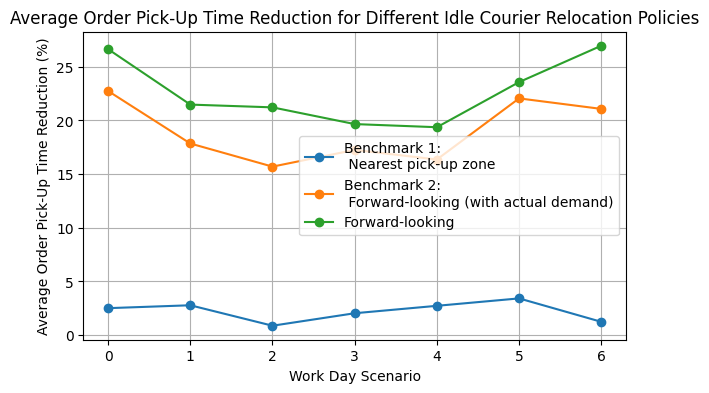

<Figure size 640x480 with 0 Axes>

In [14]:
path_ = 'Results_Saving\Simulation'
# load array data
avg_pickup_times_s1 = np.load(f'{path_}\Simu_1_avg_pickup_times.npy')
std_pickup_times_s1 = np.load(f'{path_}\Simu_1_std_pickup_times.npy')
avg_pickup_times_s2 = np.load(f'{path_}\Simu_2_avg_pickup_times.npy')
std_pickup_times_s2 = np.load(f'{path_}\Simu_2_std_pickup_times.npy')
avg_pickup_times_s3 = np.load(f'{path_}\Simu_3_avg_pickup_times.npy')
std_pickup_times_s3 = np.load(f'{path_}\Simu_3_std_pickup_times.npy')
avg_pickup_times_s4 = np.load(f'{path_}\Simu_4_avg_pickup_times.npy')
std_pickup_times_s4 = np.load(f'{path_}\Simu_4_std_pickup_times.npy')


# Calculate the mean and standard deviation along the first axis
mean_avg_pickup_times_s1 = np.mean(avg_pickup_times_s1, axis=0)
std_avg_pickup_times_s1 = np.mean(std_pickup_times_s1, axis=0)

mean_avg_pickup_times_s3 = np.mean(avg_pickup_times_s3, axis=0)
std_avg_pickup_times_s3 = np.mean(std_pickup_times_s3, axis=0)

mean_avg_pickup_times_s4 = np.mean(avg_pickup_times_s4, axis=0)
std_avg_pickup_times_s4 = np.mean(std_pickup_times_s4, axis=0)

mean_avg_pickup_times_s2 = np.mean(avg_pickup_times_s2, axis=0)
std_avg_pickup_times_s2 = np.mean(std_pickup_times_s2, axis=0)

# mean reduced avg pickup times compared to no relocation
mean_reduction_s2 = (mean_avg_pickup_times_s1 - mean_avg_pickup_times_s2)/mean_avg_pickup_times_s1
mean_reduction_s3 = (mean_avg_pickup_times_s1 - mean_avg_pickup_times_s3)/mean_avg_pickup_times_s1
mean_reduction_s4 = (mean_avg_pickup_times_s1 - mean_avg_pickup_times_s4)/mean_avg_pickup_times_s1

# Plotting the average order pick-up times with shaded area for standard deviation
plt.figure(figsize=(7, 4))


# Simulation 1
# plt.plot(mean_avg_pickup_times_s1, label='No relocation', marker='o')
# plt.fill_between(range(len(mean_avg_pickup_times_s1)), 
#                  mean_avg_pickup_times_s1 - std_avg_pickup_times_s1, 
#                  mean_avg_pickup_times_s1 + std_avg_pickup_times_s1, alpha=0.2)
# Simulation 2
plt.plot(mean_reduction_s2*100, label='Benchmark 1:\n Nearest pick-up zone', marker='o')
# Simulation 4
plt.plot(mean_reduction_s3*100, label='Benchmark 2:\n Forward-looking (with actual demand)', marker='o')
# Simulation 3
plt.plot(mean_reduction_s4*100, label='Forward-looking', marker='o')


plt.xlabel('Work Day Scenario')
plt.ylabel('Average Order Pick-Up Time Reduction (%)')
# plt.ylabel('Average Order Pick-Up Times (minutes)')
# plt.title('Comparison of Average Order Pick-Up Times Across Different Idle Courier Relocation Policies')
plt.title('Average Order Pick-Up Time Reduction for Different Idle Courier Relocation Policies')
plt.legend()
plt.grid(True)
plt.show()
plt.savefig(f'{path_}/avg_pickup_times_comparison.png')